# Final Project - Allegion






## Project Team

* Nathaniel Wise
* Pankaj Singh
* Jennifer Ma

**Introduction:**

Allegion PLC. is a company based in Dublin, Ireland with over 30 brands and connecting 130 countries (Allegion, 2021). Primarily specializing in security around a doorframe, Allegion has developed many products to keep its customers safe including: mechanical door locks, steel doors, and door frames (Allegion, 2021). Allegion has even integrated electronic products, so that a customer can ensure their property is safe, even when physically distant.  


Through our Natural Language Processing course, we were able to connect with Allegion and work with real customer reviews, providing insight into how customers felt about a product by examining the primary topics of each review, noting successes of the product and areas that could be improved. To reach our conclusions, we utilized public data provided by Allegion and performed exploratory data analysis, preprocessing, sentiment analysis, feature extraction and finally topic modeling. 


#Step 1 - Load packages

In [ ]:
#Installs
"""
In order to work correctly with pyLDAvis,
earlier versions of pandas and numpy were installed
"""
!pip install -U pandas==1.1.0
!pip install -U pyLDAvis==2.1.2
!pip install -U numpy==1.20.0
!pip install -U folium==0.2.1
!pip install -U imgaug==0.2.5
!pip install pyLDAvis
!pip install contractions
!pip install top2vec
!pip install top2vec[sentence_encoders]
!pip install tensorflow tensorflow_hub tensorflow_text
!pip install -U sentence-transformers

#Imports
import warnings
warnings.filterwarnings('ignore')

import collections
import contractions
import cufflinks as cf
import gensim
import gensim.corpora as corpora
import IPython
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd 
import plotly.graph_objs as go
import pprint
import pyLDAvis
import pyLDAvis.gensim as gensimvis
import re
import seaborn as sns
import spacy
import string
import textblob

from collections import defaultdict
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from pathlib import Path
from plotly import tools
from plotly.offline import iplot
%matplotlib inline
from pprint import pprint
from pyLDAvis.sklearn import prepare
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from wordcloud import WordCloud

#Downloads
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [2]:
#Create function to display plotly in Google colab
"""
Title: Plotly notebook mode with google colaboratory
Author: Krutchen, N.
Date: 2019
Availability: StackOverflow
Adapted from: https://stackoverflow.com/questions/47230817/plotly-notebook-mode-with-google-colaboratory
"""
def configure_plotly_browser_state():
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
  

# Step 2 - Load Data

In [ ]:
#Load data into notebook, assign to variable reviews
url='https://drive.google.com/file/d/12WjQXroha-7NaaypmXLkC9aVHfoVgUwZ/view'
file_id = url.split('/')[-2]
download_url='https://drive.google.com/uc?export=download&id=' + file_id

reviews = pd.read_csv(download_url, index_col= 0, error_bad_lines=False, encoding='UTF-16', sep='|')


# Step 3 - Data Exploratory Analysis

In [ ]:
#Obtain a general idea of what our data frame looks like
#reviews.head()

In [ ]:
# Checking if there is null data
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33100 entries, 1 to 32435
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ReviewTitle   32799 non-null  object
 1   ReviewText    32759 non-null  object
 2   StarRating    32428 non-null  object
 3   ReviewSource  32080 non-null  object
 4   ReviewDate    32070 non-null  object
dtypes: object(5)
memory usage: 1.5+ MB


In [4]:
#Remove null values
reviews = reviews.dropna()
#reviews.info()

In [5]:
#Convert StarRating to int, coerce to NA if error, drop NAs
reviews['StarRating'] = pd.to_numeric(reviews["StarRating"], errors = "coerce")
reviews = reviews.dropna()
reviews['StarRating'] = reviews['StarRating'].astype('int')

#Convert ReviewDate to datetime, coerce to NA if error, drop NAs
reviews['ReviewDate'] = pd.to_datetime(reviews['ReviewDate'], errors = "coerce")
reviews = reviews.dropna()

In [ ]:
#Get total counts of StarRating
reviews['StarRating'].value_counts()

5    22822
4     3586
1     3198
3     1406
2     1054
Name: StarRating, dtype: int64

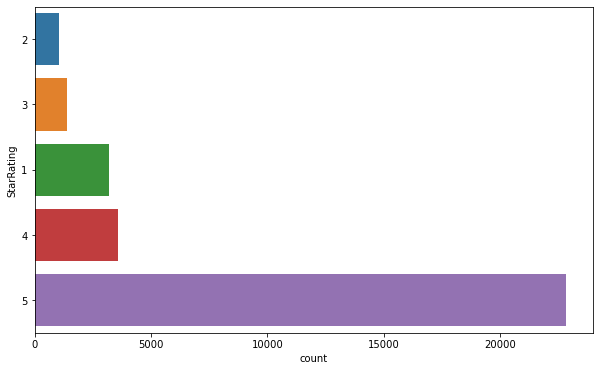

In [ ]:
#Visualize rating amount
order = reviews['StarRating'].value_counts(ascending=True).index
plt.figure(figsize=(10,6))
sns.countplot(y='StarRating', data=reviews, orient='h', order=order);

About 71% of total review have 5 star rating and just over 3% of data have 1 star

In [ ]:
#Get counts of ratings per review source
reviews['ReviewSource'].value_counts()

Stackline Star Ratings      16249
BazaarVoice Star Ratings    14292
Apple Star Ratings            985
Google Star Ratings           540
Name: ReviewSource, dtype: int64

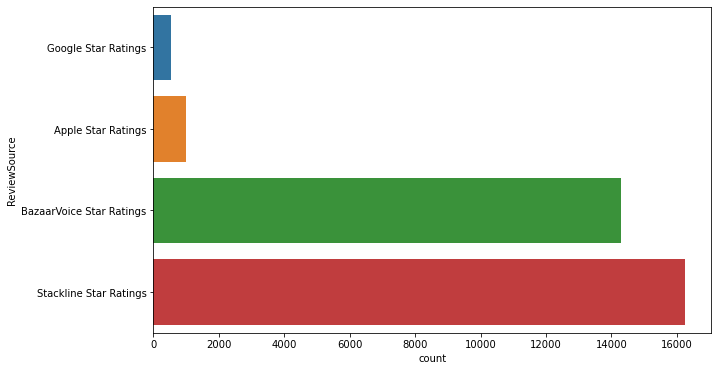

In [ ]:
#Visualize number of ratings per review source
order = reviews['ReviewSource'].value_counts(ascending=True).index
plt.figure(figsize=(10,6))
sns.countplot(y='ReviewSource', data=reviews, orient='v', order=order);

Looking at the value counts, we see that the majority of our reviews come from Stackline or BazaarVoice, while we have about 1000 from Apple and just over 500 from Google. It would be of interest to examine if there is any disparity among star ratings between platforms. 

In [ ]:
#Get mean star rating by review source
reviews.groupby(['ReviewSource']).mean()

,StarRating
ReviewSource,
Apple Star Ratings,3.252792
BazaarVoice Star Ratings,4.526378
Google Star Ratings,4.164815
Stackline Star Ratings,4.174657


<AxesSubplot:ylabel='StarRating'>

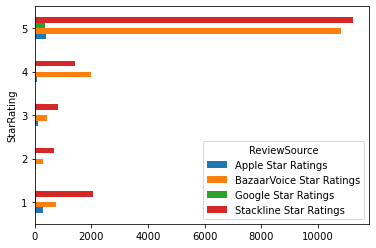

In [ ]:
#Visualize star rating counts by review source
reviews.groupby('ReviewSource').StarRating.value_counts().unstack(0).plot.barh()

We see based on the review source that BazzarVoice ratings usually are the highest at 4.5, while Stackline and Google reviews are just slightly lower at ~4.2. Surprisingly though we see a much lower rating among apple reviewers at ~3.3. We should delve into this further. Perhaps performing a temporal examination of these reviews will provide some insight into the disparity between review sources.

In [ ]:
#Check mean rating by review source over time
pd.set_option('max_rows', 100)
reviews.groupby(by=[reviews['ReviewDate'].dt.year, reviews['ReviewDate'].dt.month, 'ReviewSource']).mean()


StarRating
ReviewDate ReviewDate ReviewSource                        
1899       1          BazaarVoice Star Ratings    3.411765
2018       12         Stackline Star Ratings      4.205882
2019       1          BazaarVoice Star Ratings    4.451340
                      Stackline Star Ratings      4.229769
           2          BazaarVoice Star Ratings    4.582247
                      Stackline Star Ratings      4.140426
           3          BazaarVoice Star Ratings    4.547258
                      Stackline Star Ratings      4.253782
           4          BazaarVoice Star Ratings    4.557780
                      Stackline Star Ratings      4.056478
           5          BazaarVoice Star Ratings    4.468370
                      Stackline Star Ratings      4.320847
           6          BazaarVoice Star Ratings    4.573668
                      Stackline Star Ratings      4.332838
           7          BazaarVoice Star Ratings    4.580165
                      Stackline Star Ratings      4.344956
           8          BazaarVoice Star Ratings    4.634422
                      Stackline Star Ratings      4.243553
           9          BazaarVoice Star Ratings    4.551825
                      Stackline Star Ratings      4.125203
           10         BazaarVoice Star Ratings    4.607533
                      Stackline Star Ratings      4.192364
           11         BazaarVoice Star Ratings    4.460843
                      Stackline Star Ratings      4.176110
           12         BazaarVoice Star Ratings    4.506796
                      Stackline Star Ratings      4.261993
2020       1          Apple Star Ratings          1.368421
                      BazaarVoice Star Ratings    4.438571
                      Google Star Ratings         3.843137
                      Stackline Star Ratings      4.337638
           2          Apple Star Ratings          2.117647
                      BazaarVoice Star Ratings    4.492007
                      Google Star Ratings         4.500000
                      Stackline Star Ratings      4.344322
           3          Apple Star Ratings          3.144289
                      BazaarVoice Star Ratings    4.500000
                      Google Star Ratings         4.414286
                      Stackline Star Ratings      4.120141
           4          Apple Star Ratings          3.218750
                      BazaarVoice Star Ratings    4.517370
                      Google Star Ratings         4.033333
                      Stackline Star Ratings      4.158025
           5          Apple Star Ratings          3.357143
                      BazaarVoice Star Ratings    4.514493
                      Google Star Ratings         4.065574
                      Stackline Star Ratings      4.042129
           6          Apple Star Ratings          3.684211
                      BazaarVoice Star Ratings    4.520115
                      Stackline Star Ratings      3.932914
           7          Apple Star Ratings          3.968750
                      BazaarVoice Star Ratings    4.437209
                      Stackline Star Ratings      3.937182
           8          Apple Star Ratings          3.939394
                      Stackline Star Ratings      3.900000
           9          Apple Star Ratings          3.424242
                      Stackline Star Ratings      4.024000
           10         Apple Star Ratings          3.423077
                      Stackline Star Ratings      4.112985
           11         Apple Star Ratings          3.594595
                      Stackline Star Ratings      4.109375
           12         Apple Star Ratings          2.971429
                      Stackline Star Ratings      4.212454
2021       1          Apple Star Ratings          3.542857
                      BazaarVoice Star Ratings    4.105263
                      Stackline Star Ratings      3.982456
           2          Apple Star Ratings          3.555556
                      BazaarVoice St

In 2020 Apple ratings are introduced into this dataset and have a surprisingly low rating near 1 star in January 2020, and gradually increases. 

In [ ]:
#Add Year_Month column to data frame
reviews["year_month"] = reviews['ReviewDate'].dt.year.astype(str) + '_' + reviews['ReviewDate'].dt.month.astype(str)

# Step 4 - Data Preprocessing

## Step 4.1 Cleaning Data

In [6]:
#Ensure all null values have been removed
reviews.dropna(inplace=True)
reviews.isnull().sum()


ReviewTitle     0
ReviewText      0
StarRating      0
ReviewSource    0
ReviewDate      0
dtype: int64

In [7]:
#Removing "Not Available" reviews
reviews = reviews[~reviews.ReviewText.str.contains("Not Available")]
#reviews.count

In [ ]:
#reviews.head()

##Step 4.2 Normalize text

To normalize our text reviews for further NLP tasks, we are planning to remove emojis, stopwords, punctuation, extra newlines, extra whitespaces. From several tryouts, we noticed that "would", "could", "lock", "schlage", and "door" appear quite frequently in reviews, which do not play significant roles in text analysis, so we decided to remove them by adding the words to stopwords's list. Also, we wanted to keep "not" and "no" in our reviews for Sentiment Analysis. We also lowercase our texts, and expand contractions.





In [8]:
# Remove emojis
"""
Title: Removing emojis from a string in Python
Author: Abdul-Razak, A.
Date: 2019
Availability: StackOverflow
Adapted from: https://stackoverflow.com/a/49146722/330558
"""

def remove_emojis(text):
    emojis = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emojis, '', text)
   

In [9]:
#Remove emojis from our review text
reviews.ReviewText.apply(remove_emojis)

Id
1        It’s hit or miss if you can lock or unlock whi...
2        Since iOS 12 the locks do not respond to any s...
3        This “smart” lock is pretty atrocious. It seem...
4        This is the second time in two years the remot...
5        Attempted 10+ times to connect to the app with...
                               ...                        
32420    Everything was just as expected.  Matches the ...
32422    Schlage is the best residential lock system on...
32426    Love the square style and glad i could find th...
32427    This was the style and quality I was looking f...
32435                          Don’t care of keys any more
Name: ReviewText, Length: 29975, dtype: object

In [10]:
#Initialize WordNetLemmatizer
#Alter default stopwords

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
new_stop_words = ["door", "schlage", "lock", "would", "could"]
removed_words = ["no", "not"]
stop_words.extend(new_stop_words)
stop_words = set([word for word in stop_words if word not in removed_words])
    

In [11]:
#Remove punctuation, tokenize, remove stopwords, lemmatize
"""
Title: week3-NLP-practice
Author: Scrivner, O.
Date: 2021
Availability: IU Canvas 
Adapted from week 3 practice
"""

def normalize_corpus(review, text_lower_case=True,
                     text_lemmatization=True, text_punct=True,
                     stopword_removal=True):

           
        # normalize each document in the corpus
        # lowercase the text
        if text_lower_case:
            review = review.lower()

        # remove extra newlines
        review = re.sub(r'[\r|\n|\r\n]+', ' ', review)

        # expand contractions
        review = contractions.fix(review)

        # remove extra whitespace
        review = re.sub(' +', ' ', review)

        # remove punctuation
        if text_punct:
            tokens = word_tokenize(review)
            tokens = [token.lower() for token in tokens if token.isalpha()]
            review = ' '.join(tokens)

        #remove stopwords 
        if stopword_removal:
            tokens = word_tokenize(review)
            tokens = [token.strip() for token in tokens]
            filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
            review = ' '.join(filtered_tokens) 

        #lemmatize text    
        if text_lemmatization:
            word_list = word_tokenize(review)
            review = ' '.join([lemmatizer.lemmatize(w) for w in word_list])      
      
        return review

In [12]:
#Apply normalization function to ReviewText and place in new column
reviews['CleanText'] = reviews.ReviewText.apply(normalize_corpus)

In [ ]:
#reviews.head()

# Step 5 - Sentiment Analysis (unsupervised)

## Step 5.1 Add Sentiment

In [13]:
#Use unsupervised learning to analyze sentiment 
#Takes ~4 minutes to run

"""
Title: Sentiment Analysis
Author: Dhapola, A.
Date: 2020
Availability: Medium
Adapted from: https://medium.com/analytics-vidhya/sentiment-analysis-a360c915ff7a
"""

predicted_sentiments = []
for review in reviews['CleanText']:
  polarity = sia().polarity_scores(review)
  if polarity['neg'] < polarity['pos']:
    predicted_sentiments.append("positive")
  elif polarity['neg'] > polarity['pos']:
    predicted_sentiments.append("negative")  
  else:
    predicted_sentiments.append("neutral")  

#predicted_sentiments[:10] 

In [14]:
#Add sentiment with Vader to reviews data frame
reviews['Sentiment'] = predicted_sentiments
#print(reviews.tail())

In [15]:
#Create list of sentiments, based both on unsupervised learning and StarRating
"""
Title: How to iterate over rows in a DataFrame in Pandas
Author: Mougan, C.
Date: 2020
Availability: StackOverflow
Adapted from: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
"""

new_sentiment = []
for index, row in reviews.iterrows():
  if row["Sentiment"] == "positive" and row["StarRating"] > 3:
    new_sentiment.append("positive")
  elif row["Sentiment"] == "negative" and row["StarRating"] < 3:
    new_sentiment.append("negative")
  else:
    new_sentiment.append("neutral")   


In [16]:
#Add sentiment to data frame
reviews["Sentiment"] = new_sentiment

To further gain a better understanding of product reviews, sentiment was analyzed and added to our reviews data frame. Using nltk's SentimentIntensityAnalyzer, we obtained sentiment, but upon inspection of the predicted sentiments, we noticed that our dataframe contained may incorrect preidcitons. We elected to only sort positive and negative reivews by StarRating instead, but encountered a similar issue using this method as well; we noticed that at times, a rating would be high, but the review text contained mainly complaints about a product. To resolve this, sentiment analysis was combined with star rating to classify reviews. A review was only assesed to be positive if a sentiment prediction was positive and also had a star rating of 4-5. A review was deemed negative if a sentimet preidction was negative and also had a star rating of 1-2. All other reivews were classified as neutral. 

## Step 5.2 Analysis and Visualization of Sentiment


Title: Sentiment Analysis | Amazon reviews <br>
Author: Roshan, B.<br>
Date: 2020<br>
Availability: Kaggle<br>
Adapted from: https://www.kaggle.com/benroshan/sentiment-analysis-amazon-reviews


In [ ]:
#Get total number of reviews classified as positive/negative/neutral
reviews.Sentiment.value_counts()

positive    19836
neutral      7980
negative     2159
Name: Sentiment, dtype: int64

In [17]:
# Add 'quarter', 'Year', 'Month' columns 
reviews['quarter'] = pd.PeriodIndex(reviews.ReviewDate, freq='Q')
reviews['Year'] = pd.DatetimeIndex(reviews['ReviewDate']).year
reviews['Month'] = pd.DatetimeIndex(reviews['ReviewDate']).month

In [18]:
#Create separate dataframes based on review.
#Drop NA values if any have been erronously created
review_pos = reviews[reviews["Sentiment"]=='positive'].dropna()
review_neu = reviews[reviews["Sentiment"]=='neutral'].dropna()
review_neg = reviews[reviews["Sentiment"]=='negative'].dropna()

## Step 5.3 Visualizing Sentiment

### Sentiment Over Time


From 2018, only 34 reviews were obtained. We elected to drop those reviews in our sentiment analysis over time, examining the trends of positive and negative sentiment proportions between the quarters of 2019, 2020, and 2021.

In [ ]:
#Obtain count of sentiment values
reviews['Sentiment'].value_counts()

positive    19814
neutral     7961 
negative    2149 
Name: Sentiment, dtype: int64

In [ ]:
#Obtain counts of reviews per year
reviews['Year'].value_counts()

2019    16218
2020    12210
2021    1462 
2018    34   
Name: Year, dtype: int64

In [ ]:
#Obtain number of reviews by sentiment and year
reviews.groupby(['Year','Sentiment'])['Sentiment'].count().unstack()

Sentiment,negative,neutral,positive
Year,,,
2018,2,6,26
2019,966,3862,11390
2020,1018,3720,7472
2021,163,373,926


In [ ]:
#Remove reviews from 1899
reviews.drop(reviews[reviews['Year'] == 1899].index, inplace = True)

In [19]:
# Create a function to calculate proportions of Sentiment by quarters
def get_proportion (quarter, data_frame):
  '''quarter is the quarter of interest
    data_frame is the data frame of positive or negative sentiment
  '''
  proportion = len(data_frame.loc[data_frame['quarter'] == quarter])/len(reviews.loc[reviews['quarter'] == quarter])
  return proportion

In [20]:
# function to create lists of calculated proportions
def list_of_proportion(data_frame):
  
  quarter_list = ['2019Q1', '2019Q2', '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4', '2021Q1']
  sentiment_list = []
  for i in quarter_list:
    proportion_i = get_proportion(i, data_frame)
    sentiment_list.append(proportion_i) 

  return sentiment_list
  
  

In [21]:
#Create lists of calculated sentiment proportions
neg_sent_list = list_of_proportion(review_neg)
pos_sent_list = list_of_proportion(review_pos)
quarter_start = ['01-01-2019','04-01-2019','07-01-2019','10-01-2019','01-01-2020','04-01-2020','07-01-2020','10-01-2020','01-01-2021']

In [22]:
#Add sentiment proportion lists to data frame
proportions_df = pd.DataFrame({
    'NegSentiment': neg_sent_list,
    'PosSentiment': pos_sent_list}, 
    index = quarter_start)

Text(0, 0.5, 'Proportion of Reviews')

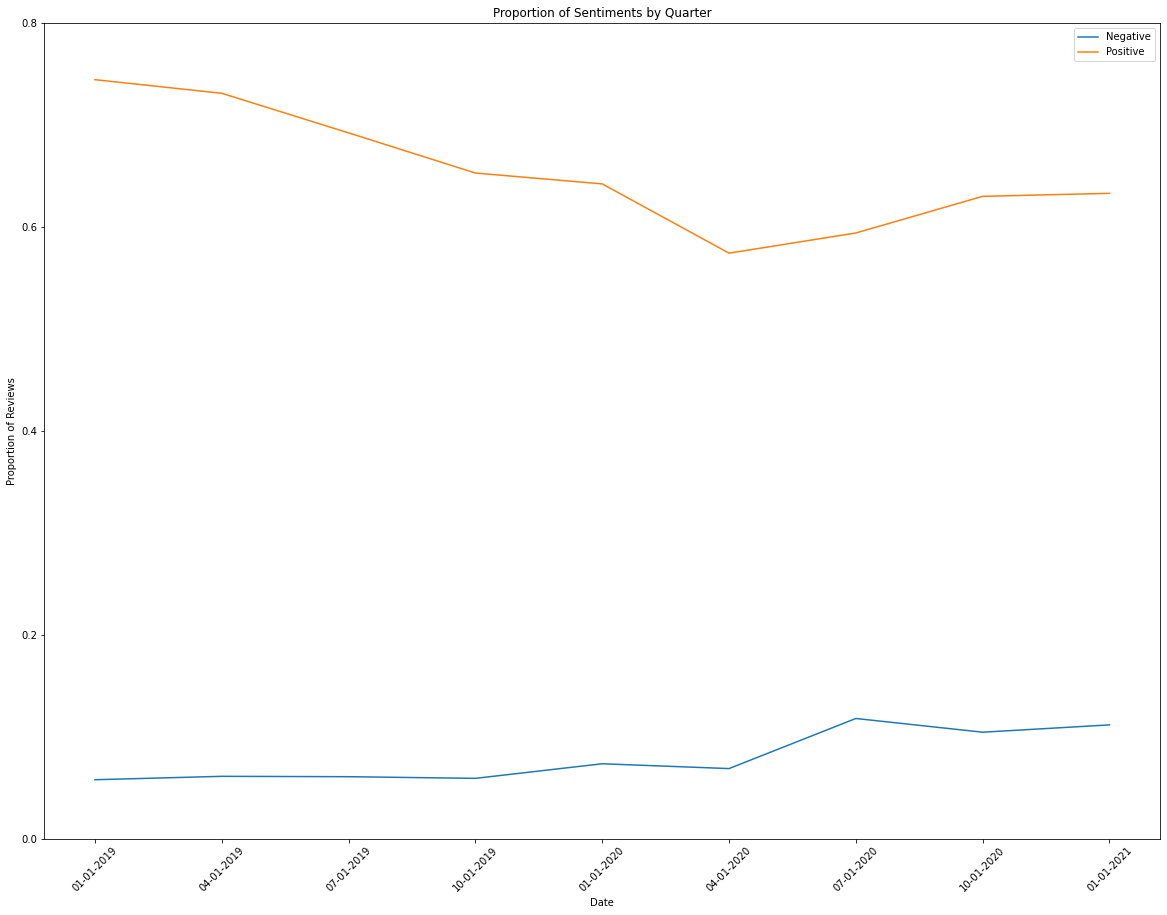

In [ ]:
#Create plot of negative and positive proportions
lines = proportions_df.plot.line(rot=45)
plt.yticks(np.arange(0,1,0.2))
new_labels = ['Negative', 'Positive']
plt.legend(labels=new_labels)
plt.title('Proportion of Sentiments by Quarter')
plt.xlabel('Date')
plt.ylabel('Proportion of Reviews')

Examining the distribution of positive and negative reviews over time, we see the majority of reivews are positive, but a slight decrease in positve (and increase in negative) reviews are observed between April 2020 and the present. 

### Polarity Distribution

Textblob was utilized to analyze sentiment polarity. Polarity of reviews are considerd positive as they approach 1 and negative as they approach -1, seen in the visualization below.

In [23]:
#Add sentiment polarity column to our data frame
reviews['polarity'] = reviews['CleanText'].map(lambda text: TextBlob(text).sentiment.polarity)

In [24]:
#Customize visualization from plotly
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [25]:
#Visualize sentiment polarity distribution
configure_plotly_browser_state()
reviews['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

Outside of neutral review outliers, we see close to a normal distribution in our reviews.

## Step 5.4 Sentiment with N-gram analysis

We are doing some visualization from n-grams analysis: unigram, bigrams, trigrams of positive, neutral and negative reviews. From the plots, we would see the top frequent words in the sentiment reviews.

### Unigram analysis


In [26]:
#Visualize most frequent unigrams by polarity
configure_plotly_browser_state()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != ""]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["CleanText"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["CleanText"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["CleanText"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/usr/local/lib/python3.7/dist-packages/plotly/basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.7/dist-packages/plotly/basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.7/dist-packages/plotly/basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




### Bi-gram analysis

In [27]:
#Visualize most frequent bigrams by polarity
configure_plotly_browser_state()
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["CleanText"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["CleanText"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["CleanText"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/usr/local/lib/python3.7/dist-packages/plotly/basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.7/dist-packages/plotly/basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.7/dist-packages/plotly/basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




### Tri-gram analysis


In [28]:
#Visualize most frequent trigrams by polarity
configure_plotly_browser_state()

## Get the bar chart from positive reviews ##
for sent in review_pos["CleanText"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["CleanText"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["CleanText"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')




# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead

/usr/local/lib/python3.7/dist-packages/plotly/basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.7/dist-packages/plotly/basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.


/usr/local/lib/python3.7/dist-packages/plotly/basedatatypes.py:1796: DeprecationWarning:

The append_trace method is deprecated and will be removed in a future version.
Please use the add_trace method with the row and col parameters.




Examining the sentiment of unigrams, bigrams, and trigrams, we found that most positive reviews referenced installation, looks, and ease of use, while most negative reviews were associated with the product’s durability, the keypad or customer service.

We observed "Provided verified purchaser" in the reviews, but elected to keep this text as we able to examine the sentiment of reviews where the purchase was verified.

# Step 6 - Keyword Extraction
- Vectorization
- Keywords Extraction using BERT for word and document embeddings 

Through the use of the BERT four-gram model, keywords were extracted by quarter from our entire dataset, as well as from subset dataframes containing only positive or negative reviews. 

In [ ]:
#reviews.head()

In [ ]:
# Create a function to split data/reviews into quarters
"""
Split data into quarters for each year of data.
start_month -- the first month of data subset we want
end_month -- the last month of data subset we want
data_frame -- DataFrame with multi-year data
"""

def get_textlist_quarter(year, start_month, end_month, data_frame):

    clean_reviews = []
    year_reviews = data_frame.loc[data_frame.Year == year, ['CleanText']]
    # "end_month" is the last month of data we want to pull, so we loop to end_month+1
    for month in range(start_month, end_month+1):
        clean_reviews = year_reviews.loc[data_frame.Month == month, ['CleanText']]
        clean_reviews = clean_reviews.CleanText.tolist()
        clean_reviews.extend(clean_reviews)
        
    return clean_reviews

In [ ]:
# Create a function to obtain keywords from the lists of reviews
# Takes ~10 minutes for our reviews dataframe to run

def get_keywords(review_list):
  n_gram_range = (1,3)

  #Extract candidate words/phrases Overall
  count = CountVectorizer(ngram_range = n_gram_range, stop_words = stop_words).fit(review_list)
  vocab = count.get_feature_names()
  
  bert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
  doc_embedding = bert_model.encode(review_list)
  word_embeddings = bert_model.encode(vocab)

  
  top_n = 10
  distances = cosine_similarity(doc_embedding, word_embeddings)
  keywords = [vocab[index] for index in distances.argsort()[0][-top_n:]]

  return keywords


## 2019 Keywords

In [ ]:
# Split data into quarters
reviews2019_q1 = get_textlist_quarter(2019,1,3,reviews)
reviews2019_q2 = get_textlist_quarter(2019,4,6,reviews)
reviews2019_q3 = get_textlist_quarter(2019,7,9,reviews)
reviews2019_q4 = get_textlist_quarter(2019,10,12,reviews)

In [ ]:
# Split quarter data into positive reviews
pos_reviews2019_q1 = get_textlist_quarter(2019, 1, 3, review_pos)
pos_reviews2019_q2 = get_textlist_quarter(2019, 4, 6, review_pos)
pos_reviews2019_q3 = get_textlist_quarter(2019, 7, 9, review_pos)
pos_reviews2019_q4 = get_textlist_quarter(2019, 10, 12, review_pos)

In [ ]:
# Split quarter data into negative reviews
neg_reviews2019_q1 = get_textlist_quarter(2019, 1, 3, review_neg)
neg_reviews2019_q2 = get_textlist_quarter(2019, 4, 6, review_neg)
neg_reviews2019_q3 = get_textlist_quarter(2019, 7, 9, review_neg)
neg_reviews2019_q4 = get_textlist_quarter(2019, 10, 12, review_neg)

### 2019 Q1 keywords

In [ ]:
#Extract keywords from reviews dataframe
get_keywords(reviews2019_q1)

['keypad perfect love',
 'doorknob buttery smooth',
 'doorknob perfect feel',
 'best apple home',
 'gorgeous doorknob match',
 'perfect update interior',
 'perfectly new mahogany',
 'keypad entry perfect',
 'work flawlessly apple',
 'flawlessly apple tv']

In [ ]:
#Extract candidate words/phrases for positive reviews
get_keywords(pos_reviews2019_q1)

['keypad perfect love',
 'doorknob buttery smooth',
 'doorknob perfect feel',
 'best apple home',
 'gorgeous doorknob match',
 'perfect update interior',
 'perfectly new mahogany',
 'keypad entry perfect',
 'work flawlessly apple',
 'flawlessly apple tv']

In [ ]:
#Extract candidate words/phrases for negative reviews
get_keywords(neg_reviews2019_q1)

['backup technology fails',
 'power outage accidentally',
 'difficult install final',
 'keypad broke reason',
 'malfunctioned locking',
 'outage accidentally unplugged',
 'looking replacement accidentally',
 'malfunctioned locking system',
 'replacement accidentally',
 'ridiculous keypad broke']

### 2019 Q2 Keywords

In [ ]:
#Extract keywords from reviews dataframe
get_keywords(reviews2019_q2)

['quality style',
 'quality info shown',
 'right price',
 'bought quality',
 'quality bit',
 'set quality bit',
 'buy quality',
 'quality item',
 'price quality',
 'quality price']

In [ ]:
#Extract candidate words/phrases for positive reviews
get_keywords(pos_reviews2019_q2)

['really happy',
 'handle happy',
 'happy product',
 'charm happy',
 'program happy',
 'application happy',
 'happy one',
 'happy',
 'happy quality',
 'happy aspect']

In [ ]:
#Extract candidate words/phrases for negative reviews
get_keywords(neg_reviews2019_q2)

['product worked failed',
 'review hoped fluke',
 'year stopped unlocking',
 'fails unlock',
 'fluke fails',
 'refurbished counterfeit poorly',
 'failed week minor',
 'fails unlock outside',
 'hoped fluke fails',
 'fluke fails unlock']

### 2019 Q3 Keywords

In [ ]:
#Extract keywords from reviews dataframe
get_keywords(reviews2019_q3)

['year stopped unlocking',
 'stop shopping month',
 'week stopped working',
 'end breaking window',
 'stopped working week',
 'week keypad shut',
 'installed month stopped',
 'month stopped working',
 'office break',
 'month locked house']

In [ ]:
#Extract candidate words/phrases for positive reviews
get_keywords(pos_reviews2019_q3)

['two work google',
 'alexa google',
 'apps amazon key',
 'app google home',
 'glitch disconnect smartphone',
 'apps renaming alexa',
 'stopper netflix',
 'stopper netflix call',
 'work alexa google',
 'spring stopper netflix']

In [ ]:
#Extract candidate words/phrases for negative reviews
get_keywords(neg_reviews2019_q3)

['day stopped working',
 'broken replace home',
 'keypad stopped working',
 'call keypad stopped',
 'stopped working bought',
 'broke stopped working',
 'end breaking window',
 'week keypad shut',
 'month stopped working',
 'month locked house']

### 2019 Q4 Keywords

In [ ]:
#Extract keywords from reviews dataframe
get_keywords(reviews2019_q4)

['work flawlessly installs',
 'install beautiful upgrade',
 'worked unlock complete',
 'keypad easiest install',
 'security easily rekeyed',
 'nickel finish everything',
 'fit finish drill',
 'complete remodeling excellent',
 'install perfect upgrade',
 'deadbolt complete upgrade']

In [ ]:
#Extract candidate words/phrases for positive reviews
get_keywords(pos_reviews2019_q4)

['flawless finish carpenter',
 'work flawlessly installs',
 'install beautiful upgrade',
 'keypad easiest install',
 'security easily rekeyed',
 'nickel finish everything',
 'fit finish drill',
 'complete remodeling excellent',
 'install perfect upgrade',
 'deadbolt complete upgrade']

In [ ]:
#Extract candidate words/phrases for negative reviews
get_keywords(neg_reviews2019_q4)

['knob failing engage',
 'turning knob deadbolt',
 'knob failing',
 'deadbolt annoying',
 'unfortunately thumb lever',
 'knob deadbolt',
 'keypad send defective',
 'automatic sound weird',
 'engaging deadbolt annoying',
 'locking handle fail']

## 2020 Keywords

In [ ]:
# Split data into quarters
reviews2020_q1 = get_textlist_quarter(2020,1,3,reviews)
reviews2020_q2 = get_textlist_quarter(2020,4,6,reviews)
reviews2020_q3 = get_textlist_quarter(2020,7,9,reviews)
reviews2020_q4 = get_textlist_quarter(2020,10,12,reviews)

In [ ]:
# Split quarter data into positive reviews
pos_reviews2020_q1 = get_textlist_quarter(2020, 1, 3, review_pos)
pos_reviews2020_q2 = get_textlist_quarter(2020, 4, 6, review_pos)
pos_reviews2020_q3 = get_textlist_quarter(2020, 7, 9, review_pos)
pos_reviews2020_q4 = get_textlist_quarter(2020, 10, 12, review_pos)

In [ ]:
# Split quarter data into negative reviews
neg_reviews2020_q1 = get_textlist_quarter(2020, 1, 3, review_neg)
neg_reviews2020_q2 = get_textlist_quarter(2020, 4, 6, review_neg)
neg_reviews2020_q3 = get_textlist_quarter(2020, 7, 9, review_neg)
neg_reviews2020_q4 = get_textlist_quarter(2020, 10, 12, review_neg)

#### 2020 Q1 Keywords

In [ ]:
#Extract keywords from reviews dataframe
get_keywords(reviews2020_q1)

['frustrating app work',
 'bot frustrating app',
 'software bad unreliable',
 'poor execution app',
 'keypad fails good',
 'alexa poor software',
 'horrible app support',
 'disappointed app update',
 'app software bad',
 'poorly designed app']

In [ ]:
#Extract candidate words/phrases for positive reviews
get_keywords(pos_reviews2020_q1)

['iphone home screen',
 'iphone ipad embarrassed',
 'rebooting apple tv',
 'device rebooting apple',
 'setting iphone app',
 'upgraded iphone',
 'work iphone unlock',
 'finished setting iphone',
 'unlocked locked iphone',
 'since upgraded iphone']

In [ ]:
#Extract candidate words/phrases for negative reviews
get_keywords(neg_reviews2020_q1)

['disappointed app',
 'poor integration apple',
 'frustrating app signed',
 'disappointed due internet',
 'bot frustrating app',
 'software bad unreliable',
 'keypad fails good',
 'disappointed app update',
 'app software bad',
 'poorly designed app']

#### 2020 Q2 Keywords

In [ ]:
#Extract keywords from reviews dataframe
get_keywords(reviews2020_q2)

['installed one used',
 'used one handle',
 'one installed',
 'bought one installed',
 'installed one installation',
 'one hardware',
 'one complaint app',
 'one installation',
 'setup app one',
 'app one device']

In [ ]:
#Extract candidate words/phrases for positive reviews
get_keywords(pos_reviews2020_q2)

['instruction easy install',
 'usage easy install',
 'happy easy install',
 'wifi easy install',
 'easy program app',
 'easy install download',
 'lockset easy install',
 'easier install app',
 'app easy use',
 'app easy installed']

In [ ]:
#Extract candidate words/phrases for negative reviews
get_keywords(neg_reviews2020_q2)

['service tried everything',
 'every review',
 'battery time already',
 'know moved first',
 'show offline first',
 'always show offline',
 'policy right away',
 'notification always',
 'notification always show',
 'push notification always']

#### 2020 Q3 Keywords

In [ ]:
#Extract keywords from reviews dataframe
get_keywords(reviews2020_q3)

['knob easy install',
 'price easy install',
 'rugged easy install',
 'great installation easy',
 'deadbolt easy install',
 'nicer cheap knob',
 'instruction cheap cable',
 'cheap expense rock',
 'kryptonite feel cheap',
 'easy installlook great']

In [ ]:
#Extract candidate words/phrases for positive reviews
get_keywords(pos_reviews2020_q3)

['schalage hardware perfect',
 'cheap knob builder',
 'knob easy install',
 'price easy install',
 'rugged easy install',
 'great installation easy',
 'deadbolt easy install',
 'nicer cheap knob',
 'cheap expense rock',
 'easy installlook great']

In [ ]:
#Extract candidate words/phrases for negative reviews
get_keywords(neg_reviews2020_q3)

['defective dripping grease',
 'keypad unresponsive prevents',
 'failing unlock randomly',
 'keypad knob disappointed',
 'unit touchpad failed',
 'fear getting hacked',
 'instruction poorly installed',
 'boy mistaken routinely',
 'mobile app disappointing',
 'unreliable locking unlocking']

#### 2020 Q4 Keywords

In [ ]:
#Extract keywords from reviews dataframe
get_keywords(reviews2020_q4)

['fabulous love',
 'absolutely perfect application',
 'happy performance',
 'awesome love one',
 'flawlessly happy purchase',
 'happy product definitely',
 'performance total star',
 'flawlessly happy',
 'work flawlessly happy',
 'happy performance total']

In [ ]:
#Extract candidate words/phrases for positive reviews
get_keywords(pos_reviews2020_q4)

['awesome respect',
 'fabulous love',
 'absolutely perfect application',
 'happy performance',
 'awesome love one',
 'flawlessly happy purchase',
 'performance total star',
 'flawlessly happy',
 'work flawlessly happy',
 'happy performance total']

In [ ]:
#Extract candidate words/phrases for negative reviews
get_keywords(neg_reviews2020_q4)

['battery go dead',
 'died completely week',
 'disappointed live michigan',
 'kryptonite disappointed live',
 'battery dead first',
 'bike stolen garage',
 'time battery dead',
 'troubleshooting website horrible',
 'alexa integration worst',
 'phone battery died']

## 2021 Keywords

In [ ]:
# Split data into quarters
reviews2021_q1 = get_textlist_quarter(2021,1,4,reviews)

In [ ]:
# Split quarter data into positive reviews
pos_reviews2021 = get_textlist_quarter(2021, 1, 4, review_pos)

In [ ]:
# Split quarter data into negative reviews
neg_reviews2021 = get_textlist_quarter(2021, 1, 4, review_neg)

#### 2021 Q1 Keywords
 

In [ ]:
#Extract keywords from reviews dataframe
get_keywords(reviews2021_q1)

['without bike mount',
 'wifi not',
 'unless using key',
 'lost remote connectivity',
 'bluetooth no option',
 'requires internet',
 'adapter wifi not',
 'requires internet connection',
 'key requires internet',
 'wifi not connecting']

In [ ]:
#Extract candidate words/phrases for positive reviews
get_keywords(pos_reviews2021)

['phone reinstall code',
 'fixed changing auto',
 'issue old keypad',
 'changing auto delay',
 'old keypad dead',
 'keypad dead bolt',
 'twice basic quickset',
 'rental cost twice',
 'app change phone',
 'security deadbolt exactly']

In [ ]:
#Extract candidate words/phrases for negative reviews
get_keywords(neg_reviews2021)

['using key requires',
 'not like unlock',
 'wifi not',
 'unless using key',
 'bluetooth no option',
 'requires internet',
 'adapter wifi not',
 'requires internet connection',
 'key requires internet',
 'wifi not connecting']

In 2019 positive reviews centered around appreciation for the design and ease of installation, while negative reviews revolved around product durability of mechanical parts such as the deadbolt and keypad. 

The ease of install and appearance of the product continued to trend in 2020 adding price as another positive aspect. The beginning of 2020 had negative reviews centered around the mobile application (particularly for Apple phones) as well as customer service; the later portion of 2020 had complaints focused on the keypad and battery, similar to complaints in 2019.

While fewer reviews were obtained in 2021, we see mostly positive reviews where customers were happy with the performance of the product; complaints again revolved around the battery, however the keypad was not mentioned.   

# Step 7 - Topic Analysis over time and Visualization

In [ ]:
"""
Title: Topic Modeling
Author: Kurt, Senol
Date: Jun 29, 2020
Availability: Medium
Adapted from: https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-3-ab03e01b7cd7
"""

'\nTitle: Topic Modeling\nAuthor: Kurt, Senol\nDate: Jun 29, 2020\nAvailability: Medium\nAdapted from: https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-3-ab03e01b7cd7\n'

## Step 7.1 Topic Modeling

In [ ]:
#Create an array of reviews from our cleaned text
review_array = np.array(reviews['CleanText'])
#review_array[:5]

In [ ]:
#Tokenize review_array
wpt = nltk.WordPunctTokenizer()
token_data = [wpt.tokenize(document) for document in review_array]
#token_data[0]

In [ ]:
# Build the bigram, trigram and fourgram models
bigram = gensim.models.Phrases(token_data, min_count=20, threshold=20) 
trigram = gensim.models.Phrases(bigram[token_data], threshold=10)  
fourgram = gensim.models.Phrases(trigram[token_data], threshold=10) 

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
fourgram_mod = gensim.models.phrases.Phraser(fourgram) 

#print(fourgram_mod[token_data[1]][:10])

In [ ]:
# bi-gram, tri-gram and four-gram implementation
texts = [bigram_mod[doc] for doc in token_data]
texts = [trigram_mod[bigram_mod[doc]] for doc in token_data]
texts = [fourgram_mod[trigram_mod[doc]] for doc in token_data]  


In [ ]:
# Build Vocabulary
id2word = corpora.Dictionary(texts)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 14709


In [ ]:
#Add vocabulary to corpus
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
#Checking the frequency of words in vocabulary to determine if we should filter out words that occur too frequent
dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if id2word[idx] in dict_corpus:
      dict_corpus[id2word[idx]] += freq
    else:
       dict_corpus[id2word[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

In [ ]:
#Describe corpus by frequency
dict_df.describe()

,freq
count,14709.000000
mean,27.132980
std,175.084756
min,1.000000
25%,1.000000
50%,3.000000
75%,11.000000
max,12670.000000


In [ ]:
#Obtain most frequent values 
# dict_df.sort_values('freq', ascending=False).head(10)
print(dict_df.sort_values('freq', ascending= False))

               freq
not           12670
easy_install   4683
one            4637
great          4070
product        3565
...             ...
irritates         1
sseless           1
waspretty         1
relaxed           1
alaays            1

[14709 rows x 1 columns]


In [ ]:
#Filter extreme words with freq > 4710 as we are focusing on noun words more to categorize 
extension = dict_df[dict_df.freq>4710].index.tolist()
ids=[id2word.token2id[extension[i]] for i in range(len(extension))]
id2word.filter_tokens(bad_ids=ids)

In [ ]:
# Filter out words that occur less than 10 documents, or more than
# 60% of the documents.
id2word.filter_extremes(no_below=10, no_above=0.6)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 3989


In [ ]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

## Step 7.2 LDA Mallet Implementation

In [ ]:
#Get mallet.zip file
"""
Title: Topic Modeling - LDA Mallet Implementation in Python
Author: Kurt, S.
Date: 2020
Availability: Medium
Adapted from: https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-3-ab03e01b7cd7
"""

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [ ]:
#Unzip obtained mallet file
!unzip mallet-2.0.8.zip

In [ ]:
#Define path to the mallet binary to pass in LdaMallet wrapper
mallet_path = Path(os.getcwd(), 'mallet-2.0.8/bin/mallet')

In [ ]:
#Implement LDA with Malet
ldamallet = gensim.models.wrappers.LdaMallet(str(mallet_path), corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [ ]:
# Display topics
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('handle', 0.10778181818181819),
   ('knob', 0.0853090909090909),
   ('door', 0.03192727272727273),
   ('beautiful', 0.024727272727272726),
   ('hardware', 0.02338181818181818),
   ('replaced', 0.0232),
   ('finish', 0.022872727272727274),
   ('feel', 0.02109090909090909),
   ('match', 0.020181818181818183),
   ('replace', 0.015818181818181818)]),
 (1,
  [('app', 0.07333269482488906),
   ('work', 0.04817546212048655),
   ('feature', 0.024359097149059795),
   ('wifi', 0.021038853238834084),
   ('phone', 0.01982568719471315),
   ('connect', 0.017910161861890622),
   ('alexa', 0.017590907639753534),
   ('home', 0.01749513137311241),
   ('code', 0.01650544328448744),
   ('smart', 0.014302589151741532)]),
 (2,
  [('set', 0.07758025229941469),
   ('installed', 0.057948885738175734),
   ('install', 0.05733086123532192),
   ('installation', 0.03566364925291744),
   ('easy', 0.03453666339477224),
   ('needed', 0.029701530519504128),
   ('purchased', 0.028065583306067548),
   ('instructi

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.624560099207214


In [ ]:
# Topic distribution for each doc in the corpus
tm_results = ldamallet[corpus]

In [ ]:
# The most dominant topics of all docs in a corpus
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [ ]:
# Top 10 terms and probabilities for each topic
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=10)] for n in range(0, ldamallet.num_topics)]

In [ ]:
# Create a data frame of term-topic
term_topic_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 11)],
                         index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
print(term_topic_df.head())

         Topic 1  Topic 2       Topic 3                             Topic 4  \
Term1     handle      app           set                             product   
Term2       knob     work     installed                               great   
Term3       door  feature       install                                good   
Term4  beautiful     wifi  installation  rating_provided_verified_purchaser   
Term5   hardware    phone          easy                             quality   

       Topic 5       Topic 6 Topic 7 Topic 8 Topic 9  Topic 10  
Term1     work  easy_install    bike    lock     key  deadbolt  
Term2     time          love  secure  bought    code     screw  
Term3     year    work_great   chain     buy    open    inside  
Term4  battery         great   heavy   house  unlock     lever  
Term5    month    look_great    make    home  keypad      part  


In [ ]:
# We could also set column width and create a data frame of topic as index and terms in columns
pd.set_option('display.max_colwidth', -1)
topic_term_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
print(topic_term_df)

                                                                                                     Terms per Topic
Topic1   handle, knob, door, beautiful, hardware, replaced, finish, feel, match, replace                            
Topic2   app, work, feature, wifi, phone, connect, alexa, home, code, smart                                         
Topic3   set, installed, install, installation, easy, needed, purchased, instruction, item, find                    
Topic4   product, great, good, rating_provided_verified_purchaser, quality, nice, sturdy, price, easy_install, solid
Topic5   work, time, year, battery, month, issue, worked, replacement, problem, day                                 
Topic6   easy_install, love, work_great, great, look_great, easy, nice, perfect, work_well, easy_use                
Topic7   bike, secure, chain, heavy, make, long, cable, kryptonite, easily, cut                                     
Topic8   lock, bought, buy, house, home, make, installed, brand,

#### Categories

* **Topic1 - Product appearance**
* **Topic2 - Smart features**
* **Topic3 - Product installation**
* **Topic4 - General appreciation**
* **Topic5 - Issue with product**
* **Topic6 - Product quality appreciation**
* **Topic7 - Bicycle products**
* **Topic8 - Motivating factor for purchase**
* **Topic9 - Product operation**
* **Topic10 - Parts**

In [ ]:
#Set word cloud parameters
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [ ]:
plt.rcParams['figure.figsize'] = [20, 15]

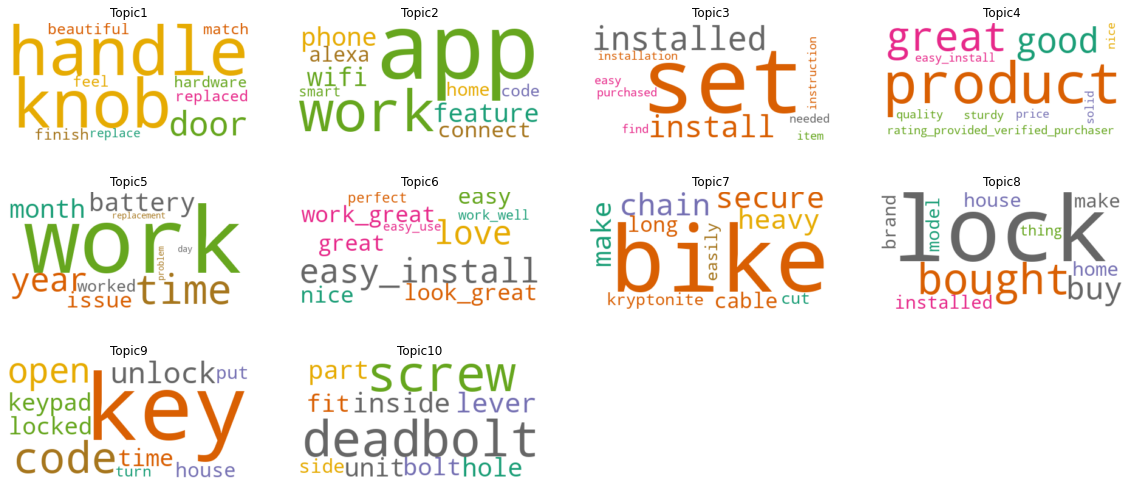

In [ ]:
# Create subplots for each topic
for i in range(10):
    wc.generate(text=topic_term_df["Terms per Topic"][i])
    #wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topic_term_df.index[i])
    #plt.title(topics_df.index[i])

plt.show()

In [ ]:
#Function to obtain gensim model from LDA Mallet
def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
#Obtain gensim model from LDA Mallet
ldagensim = convertldaMalletToldaGen(ldamallet)

In [ ]:
#Visualize topics dynamically
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(ldagensim, corpus, id2word, sort_topics=False)
pyLDAvis.display(vis_data)

In [ ]:
# Create a dataframe 
corpus_topic_df = pd.DataFrame()

# Get the Titles, ReviewSource, StarRating from the original dataframe
corpus_topic_df['ReviewSource'] = reviews.ReviewSource
corpus_topic_df['StarRating'] = reviews.StarRating
corpus_topic_df['Sentiment'] = reviews.Sentiment

corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topic_term_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]

#corpus_topic_df

In [ ]:
#Dominant topics in the entire corpus
dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df.sort_values(by = ['Doc_Count'], ascending=False)

,Dominant Topic,Doc_Count,Total_Docs_Perc
3,4,5947,19.87
5,6,4503,15.05
0,1,4429,14.80
1,2,2958,9.89
4,5,2257,7.54
6,7,2252,7.53
2,3,2224,7.43
8,9,1891,6.32
9,10,1880,6.28
7,8,1583,5.29


In [ ]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

,ReviewSource,StarRating,Sentiment,Dominant Topic,Contribution %,Topic Terms
0,BazaarVoice Star Ratings,1,neutral,1,40.74,"handle, knob, door, beautiful, hardware, replaced, finish, feel, match, replace"
1,Stackline Star Ratings,5,neutral,2,45.67,"app, work, feature, wifi, phone, connect, alexa, home, code, smart"
2,BazaarVoice Star Ratings,4,neutral,3,26.32,"set, installed, install, installation, easy, needed, purchased, instruction, item, find"
3,Stackline Star Ratings,5,positive,4,21.48,"product, great, good, rating_provided_verified_purchaser, quality, nice, sturdy, price, easy_install, solid"
4,Stackline Star Ratings,3,neutral,5,36.75,"work, time, year, battery, month, issue, worked, replacement, problem, day"
5,Stackline Star Ratings,5,positive,6,19.25,"easy_install, love, work_great, great, look_great, easy, nice, perfect, work_well, easy_use"
6,Stackline Star Ratings,4,neutral,7,49.88,"bike, secure, chain, heavy, make, long, cable, kryptonite, easily, cut"
7,Stackline Star Ratings,1,negative,8,44.44,"lock, bought, buy, house, home, make, installed, brand, model, thing"
8,BazaarVoice Star Ratings,5,positive,9,46.77,"key, code, open, unlock, keypad, locked, time, house, put, turn"
9,Stackline Star Ratings,4,positive,10,42.17,"deadbolt, screw, inside, lever, part, hole, unit, bolt, fit, side"


In [ ]:
#Create dataframe with topic weights
df_weights = pd.DataFrame.from_records([{v: k for v, k in row} for row in tm_results])
df_weights.columns = ['Topic ' + str(i) for i in range(1,11)]
df_weights

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,0.094340,0.113208,0.094340,0.094340,0.113208,0.094340,0.094340,0.094340,0.113208,0.094340
1,0.069444,0.165123,0.106481,0.086420,0.128086,0.069444,0.083333,0.145062,0.074074,0.072531
2,0.077944,0.220564,0.074627,0.084577,0.147595,0.074627,0.094527,0.074627,0.074627,0.076285
3,0.069264,0.186147,0.067821,0.064935,0.160173,0.088023,0.073593,0.103896,0.086580,0.099567
4,0.083333,0.166667,0.083333,0.083333,0.144444,0.083333,0.083333,0.100000,0.088889,0.083333
...,...,...,...,...,...,...,...,...,...,...
29919,0.148148,0.092593,0.092593,0.111111,0.092593,0.092593,0.092593,0.092593,0.092593,0.092593
29920,0.079365,0.095238,0.095238,0.107584,0.104056,0.079365,0.102293,0.146384,0.111111,0.079365
29921,0.150659,0.084746,0.101695,0.086629,0.084746,0.101695,0.084746,0.118644,0.084746,0.101695
29922,0.117647,0.088235,0.086601,0.088235,0.076797,0.083333,0.073529,0.088235,0.173203,0.124183


In [ ]:
#Add quarter and sentiment to topic weights
df_weights['Quarter'] = reviews['quarter'].dt.strftime('%Y_Q%q').values
df_weights['Sentiment'] = reviews['Sentiment'].values

In [ ]:
#df_weights

In [ ]:
# Get yearly average weights of topics for each doc
df_weights.groupby('Quarter').mean()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
Quarter,,,,,,,,,,
2018_Q4,0.094667,0.098161,0.094730,0.097562,0.099859,0.099323,0.096674,0.105715,0.108970,0.104339
2019_Q1,0.102543,0.098182,0.100224,0.100311,0.099826,0.101829,0.097332,0.099662,0.100083,0.100007
2019_Q2,0.101517,0.098724,0.099853,0.100170,0.099620,0.100984,0.099439,0.099875,0.100197,0.099619
2019_Q3,0.101346,0.098772,0.099930,0.100576,0.098835,0.100589,0.100839,0.099688,0.099600,0.099824
2019_Q4,0.101120,0.098683,0.099997,0.101353,0.099855,0.101018,0.099231,0.099293,0.099562,0.099887
2020_Q1,0.098214,0.106591,0.099278,0.099439,0.100796,0.100408,0.097826,0.098938,0.099969,0.098542
2020_Q2,0.101426,0.098287,0.099354,0.103135,0.100269,0.099982,0.100079,0.098733,0.098507,0.100228
2020_Q3,0.097708,0.100473,0.099457,0.096479,0.102741,0.096149,0.104921,0.099712,0.100808,0.101551
2020_Q4,0.097277,0.102515,0.098535,0.097730,0.102851,0.097037,0.103293,0.100433,0.099852,0.100477


In [ ]:
# get the dominant topic in each doc
df_weights['Dominant'] = df_weights.drop(["Sentiment", "Quarter"], axis=1).idxmax(axis=1)
df_weights.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Quarter,Sentiment,Dominant
0,0.094340,0.113208,0.094340,0.094340,0.113208,0.094340,0.094340,0.094340,0.113208,0.094340,2020_Q1,neutral,Topic 2
1,0.069444,0.165123,0.106481,0.086420,0.128086,0.069444,0.083333,0.145062,0.074074,0.072531,2020_Q1,neutral,Topic 2
2,0.077944,0.220564,0.074627,0.084577,0.147595,0.074627,0.094527,0.074627,0.074627,0.076285,2020_Q1,neutral,Topic 2
3,0.069264,0.186147,0.067821,0.064935,0.160173,0.088023,0.073593,0.103896,0.086580,0.099567,2020_Q1,negative,Topic 2
4,0.083333,0.166667,0.083333,0.083333,0.144444,0.083333,0.083333,0.100000,0.088889,0.083333,2020_Q1,neutral,Topic 2


In [ ]:
#Get dominant topic per quarter
df_dominance = df_weights.groupby('Quarter')['Dominant'].value_counts(normalize=True).unstack()

df_dominance.reset_index(inplace=True)
df_melted = df_dominance.melt(id_vars=['Quarter'], value_vars=['Topic ' + str(i) for i in range(1,11)], var_name='Topic', value_name='Prevelance')
df_melted

,Quarter,Topic,Prevelance
0,2018_Q4,Topic 1,0.029412
1,2019_Q1,Topic 1,0.179207
2,2019_Q2,Topic 1,0.168081
3,2019_Q3,Topic 1,0.160591
4,2019_Q4,Topic 1,0.149108
...,...,...,...
105,2020_Q2,Topic 10,0.058871
106,2020_Q3,Topic 10,0.077105
107,2020_Q4,Topic 10,0.076558
108,2021_Q1,Topic 10,0.071277


In [ ]:
df_melted = df_melted.sort_values(by=['Quarter'])

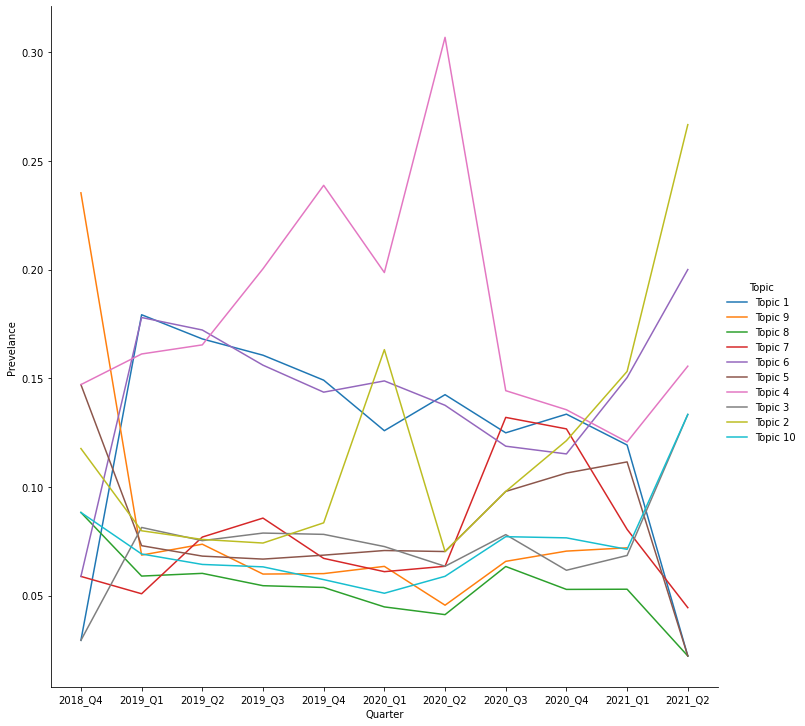

In [ ]:
#Plot dominant topics over time
sns.relplot(x='Quarter', y="Prevelance", hue='Topic', data=df_melted, kind="line", height=10, style="Topic", dashes=False, ci=None, )

In [ ]:
#View topic weights bsed on sentiment over time
df_sentiment = df_weights.groupby(['Sentiment', 'Quarter'])['Dominant'].value_counts(normalize=True).unstack()
df_sentiment.head(15)

Dominant            Topic 1  Topic 10   Topic 2   Topic 3   Topic 4   Topic 5  \
Sentiment Quarter                                                               
negative  2018_Q4 NaN       NaN       NaN       NaN       NaN        1.000000   
          2019_Q1  0.118943  0.140969  0.083700  0.092511  0.022026  0.330396   
          2019_Q2  0.062780  0.170404  0.071749  0.094170  0.017937  0.345291   
          2019_Q3  0.054622  0.126050  0.079832  0.117647  0.021008  0.340336   
          2019_Q4  0.061151  0.165468  0.100719  0.097122  0.032374  0.363309   
          2020_Q1  0.046961  0.093923  0.276243  0.080110  0.022099  0.298343   
          2020_Q2  0.059289  0.134387  0.083004  0.090909  0.023715  0.383399   
          2020_Q3  0.032129  0.132530  0.100402  0.076305  0.024096  0.337349   
          2020_Q4  0.045455  0.116883  0.084416  0.090909  0.032468  0.389610   
          2021_Q1  0.063291  0.101266  0.189873  0.082278  0.012658  0.411392   
          2021_Q2 NaN       NaN        0.600000 NaN       NaN        0.200000   
neutral   2018_Q4 NaN        0.166667 NaN       NaN        0.166667 NaN         
          2019_Q1  0.172237  0.097686  0.107969  0.105398  0.075835  0.163239   
          2019_Q2  0.144928  0.108037  0.108037  0.085639  0.084321  0.133070   
          2019_Q3  0.132095  0.081527  0.079463  0.065015  0.241486  0.110423   

Dominant            Topic 6   Topic 7   Topic 8   Topic 9  
Sentiment Quarter                                          
negative  2018_Q4 NaN       NaN       NaN       NaN        
          2019_Q1  0.004405  0.074890  0.061674  0.070485  
          2019_Q2  0.008969  0.094170  0.062780  0.071749  
          2019_Q3  0.004202  0.147059  0.050420  0.058824  
          2019_Q4  0.003597  0.064748  0.039568  0.071942  
          2020_Q1  0.002762  0.055249  0.052486  0.071823  
          2020_Q2 NaN        0.090909  0.067194  0.067194  
          2020_Q3  0.004016  0.152610  0.076305  0.064257  
          2020_Q4 NaN        0.123377  0.051948  0.064935  
          2021_Q1  0.006329  0.056962  0.031646  0.044304  
          2021_Q2 NaN        0.200000 NaN       NaN        
neutral   2018_Q4 NaN        0.166667  0.166667  0.333333  
          2019_Q1  0.035990  0.086118  0.071979  0.083548  
          2019_Q2  0.042161  0.121212  0.077734  0.094862  
          2019_Q3  0.034056  0.112487  0.070175  0.073271

In [ ]:
#Obtain dominant topic and sentiment over time
df_sentiment.reset_index(inplace=True)
df_melted = df_sentiment.melt(id_vars=['Sentiment', 'Quarter'], value_vars=['Topic ' + str(i) for i in range(1,11)], var_name='Topic', value_name='Prevelance')
df_melted

,Sentiment,Quarter,Topic,Prevelance
0,negative,2018_Q4,Topic 1,NaN
1,negative,2019_Q1,Topic 1,0.118943
2,negative,2019_Q2,Topic 1,0.062780
3,negative,2019_Q3,Topic 1,0.054622
4,negative,2019_Q4,Topic 1,0.061151
...,...,...,...,...
325,positive,2020_Q2,Topic 10,0.045347
326,positive,2020_Q3,Topic 10,0.054936
327,positive,2020_Q4,Topic 10,0.063441
328,positive,2021_Q1,Topic 10,0.049052


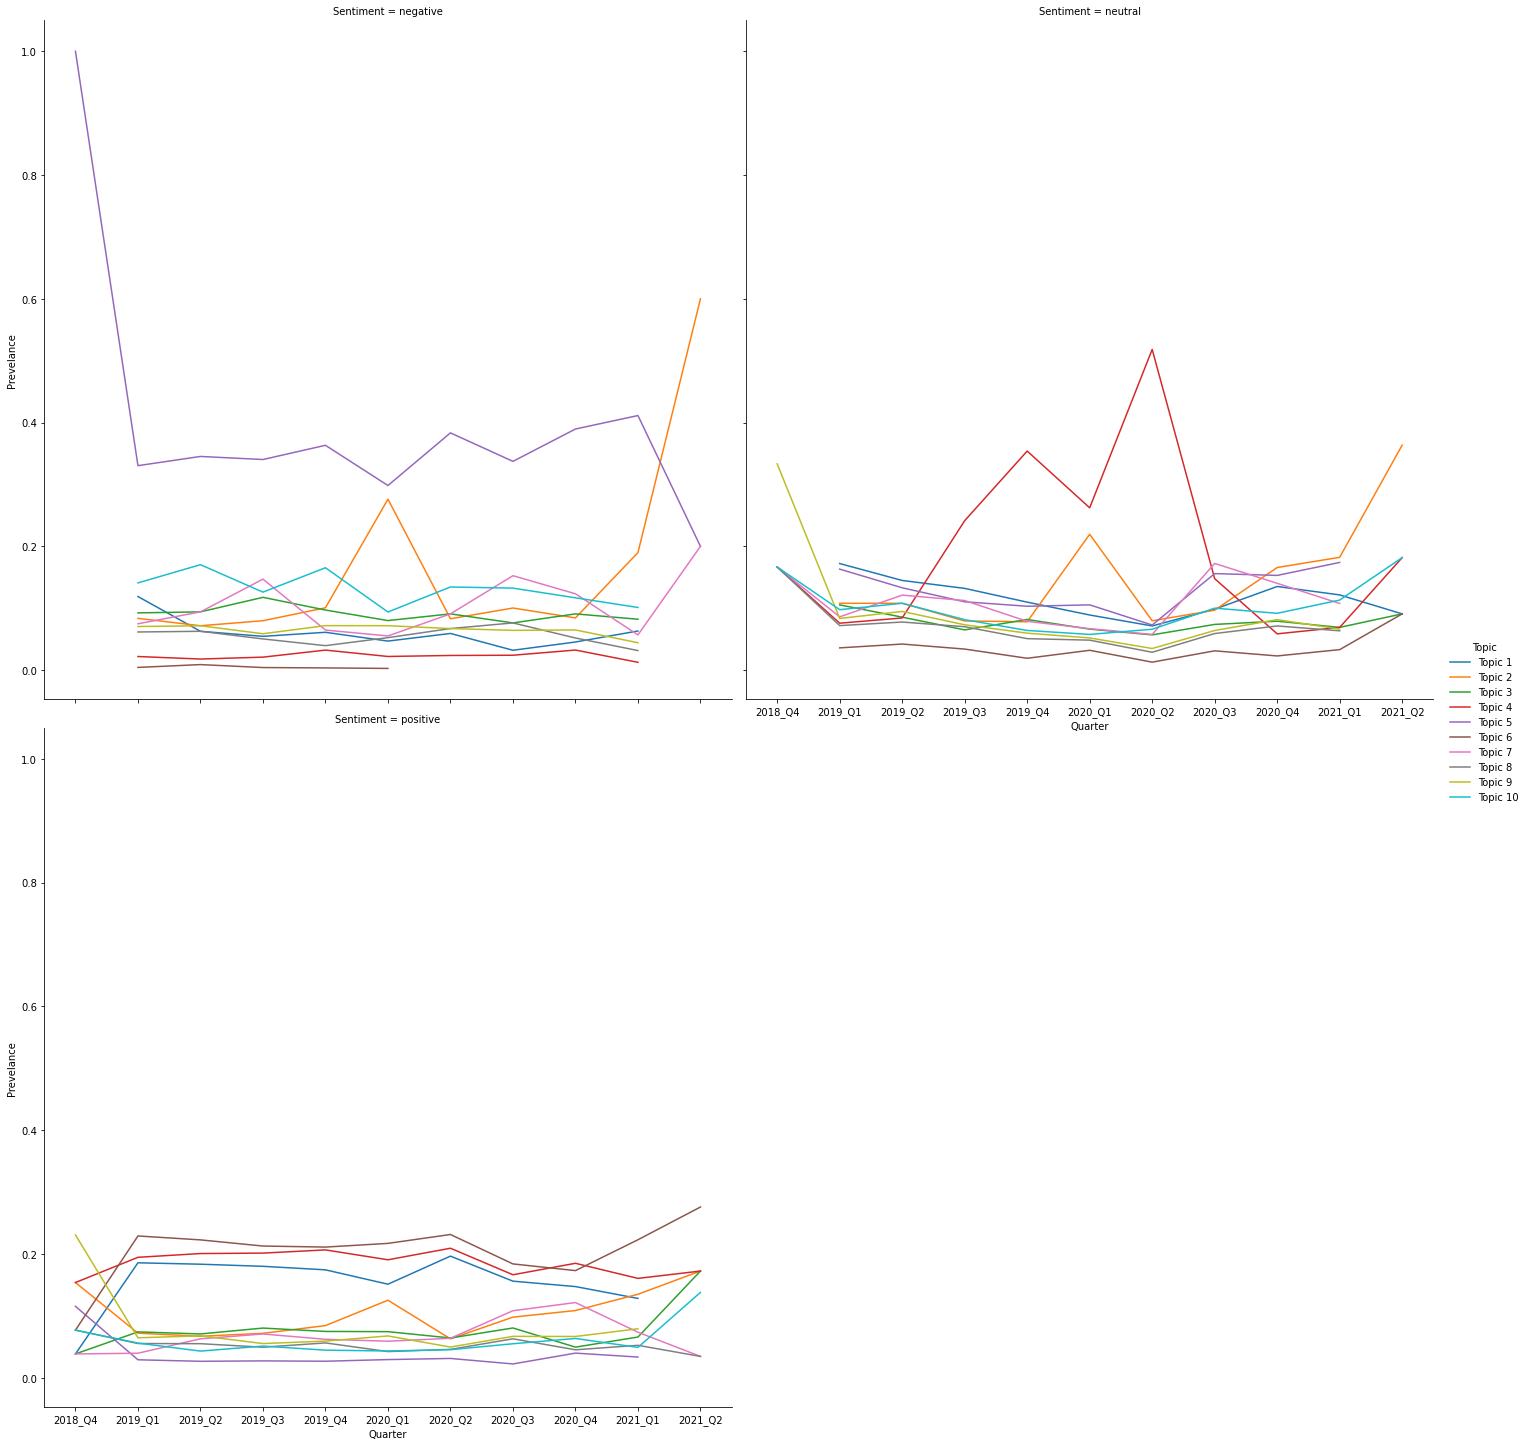

In [ ]:
#Visualize dominant topics over time by sentiment
sns.relplot(x='Quarter', y="Prevelance", col="Sentiment", col_wrap=2, hue='Topic', data=df_melted, kind="line", height=10, style="Topic", dashes=False, ci=None)

Converting the ‘CleanText’ column from our reviews dataframe to an array, text was tokenized and a four-gram model was built. We found a vocabulary size of 14,686 unique values and filtered out words with extremely high or low frequencies, integrating the filtered vocabulary to a bag-of-words. 

From the bag-of-words, LDA Mallet was used to generate 10 topics; these topics were then visualized using word clouds and dynamic visualizations using pyLDAvis. A dominant topic was assigned to each review based on contribution percentage. Topic weights were also evaluated by quarter and visualized over time, both overall and by sentiment associated with the review. 

We observed that, overall, Topic (General Appreciation) has the highest prevalence. Examining negative sentiments, we see that Topic 5 (Product Issues) is the highest occurring topic until 2021, taken over by a sharp rise of reviews associated with Topic 2 (Smart Features), while Topic 6 (Product Quality Appreciation) was least prominent topic (Figure 9). Positive reviews were mainly associated with Topic 6 and Topic 4 (Product Quality Appreciation and General Appreciation, respectively), however at the end of 2020 the prevalence of Topic 4 (General Appreciation) began to decrease; Topic 5 (Product Issues) was the least associated with positive reviews (Figure 10).


# Step 8 - Data Export

In [ ]:
#Export data
reviews.insert(0, 'Dominant Topic', corpus_topic_df['Dominant Topic'])
reviews.to_csv('StarRating.csv')  

# Step 9 - Conclusion

Through our analysis of Allegion reviews, just over 33,000 reviews were explored over time using sentiment analysis, feature (keyword) extraction, and topic modeling . We observed that while most reviews were positive, there was a decline in positive reviews in the beginning of 2020 that is still continuing to recover. Most positive reviews centered around installation, appearance, and ease of use. Most negative reviews were associated with the product durability, the keypad, or customer service. However, in the beginning of 2020 many negative reviews centered around the Allegion’s mobile application. Finally, topics were modeled temporally. We found topics in positive reviews remained consistent over time, while topics associated with negative reviews tended to fluctuate more. Our findings were incorporated into a data frame and exported to a .csv file. Our final report along with the .csv file is included with this notebook.

# References

  Allegion. (2021). About Allegion. https://www.allegion.com/corp/en/about.html  

  Abdul-Razak, A. (2019). Removing emojis from a string in Python. StackOverflow. https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python/49146722#49146722

  Dhapola, A. (2020). Sentiment Analysis. Medium. https://medium.com/analytics-vidhya/sentiment-analysis-a360c915ff7a

  Kurt, S. (2020). Topic Modeling - LDA Mallet Implementation in Python. Medium. https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-3-ab03e01b7cd7

  Kruchten, N. (2019). Plotly notebook mode with google colaboratory. StackOverflow. https://stackoverflow.com/questions/47230817/plotly-notebook-mode-with-google-colaboratory

  Mougan, C. (2020). How to iterate over rows in a DataFrame in Pandas. StackOverflow. https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas

  Roshan, B. (2020). Sentiment Analysis | Amazon reviews. Kaggle. https://www.kaggle.com/benroshan/sentiment-analysis-amazon-reviews 

Sarkar, D. (2016). Text Analytics with Python: A Practical Real-World Approach to Gaining Actionale Insights from your Data. Apress.

Scrivner, O. (2021). week3-NLP-practice from Personal Collection of (Olga Scrivner), Indiana University, Bloomington, IN.